In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
data = pd.read_excel("../../data/covid-indo/raw/Daily Update Data Agregat Covid-19 Jakarta.xlsx", sheet_name="Data Jakarta")
data.head()

,Tanggal,Jam,Tanggal Jam,Meninggal,Sembuh,Self Isolation,Masih Perawatan,Total Pasien,Positif Harian,Positif Aktif,Sembuh Harian,Tanpa Gejala,Bergejala,Belum Ada Data
0,2020-03-01,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN
1,2020-03-02,NaN,NaN,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2020-03-03,NaN,NaN,1,0,0,2,3,3,2,0,NaN,NaN,NaN
3,2020-03-04,NaN,NaN,1,0,0,2,3,0,2,0,NaN,NaN,NaN
4,2020-03-05,NaN,NaN,3,0,0,4,7,4,4,0,NaN,NaN,NaN


# Positif Harian Forecasting

In [19]:
import warnings
warnings.filterwarnings("ignore")

positif_harian = data[["Tanggal", "Positif Harian"]]
positif_harian["Tanggal"] = pd.to_datetime(positif_harian["Tanggal"])
positif_harian.set_index("Tanggal", inplace=True)
positif_harian.head()

,Positif Harian
Tanggal,
2020-03-01,0
2020-03-02,0
2020-03-03,3
2020-03-04,0
2020-03-05,4


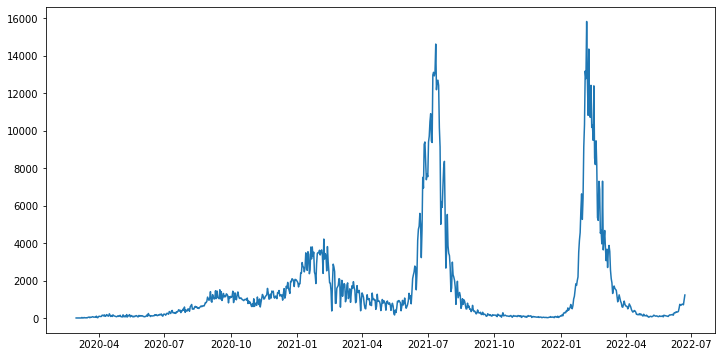

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(positif_harian.index, positif_harian["Positif Harian"])
plt.show()

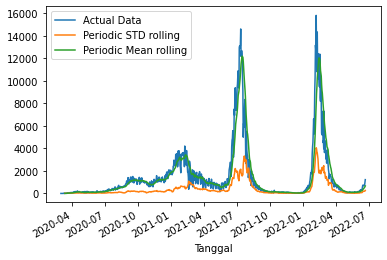

In [22]:
positif_harian_rolling = positif_harian.copy()

plt.plot(positif_harian.index,
         positif_harian["Positif Harian"], label="Actual Data")
positif_harian_rolling["Positif Harian"].rolling(12).std().plot(label="Periodic STD rolling")
positif_harian_rolling["Positif Harian"].rolling(12).mean().plot(label="Periodic Mean rolling")
plt.legend()
plt.show()

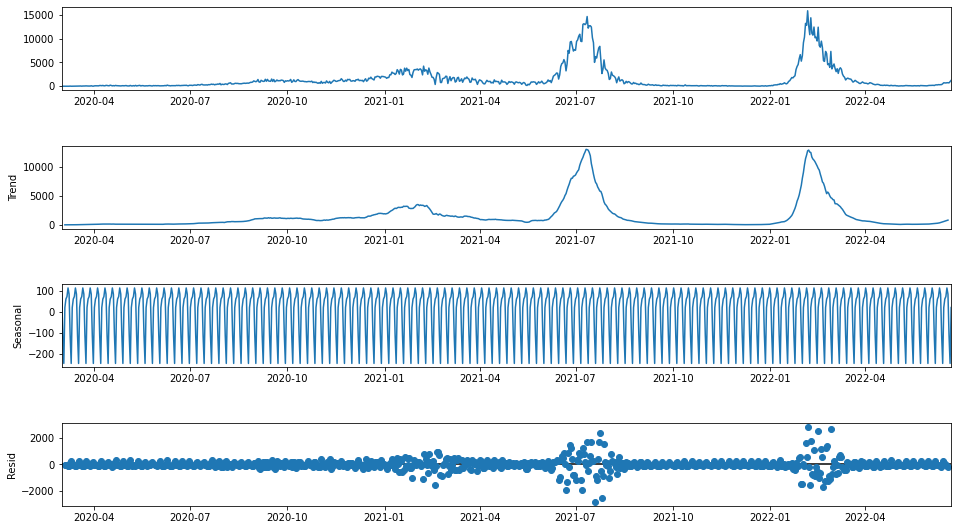

In [23]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompose = seasonal_decompose(positif_harian_rolling)
fig = decompose.plot()
fig.set_size_inches(15, 8)

In [24]:
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")
result = adfuller(positif_harian)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -4.219197
p-value: 0.000611


p-valuenya < 5%, berarti dia aman sih, ga perlu cari d order

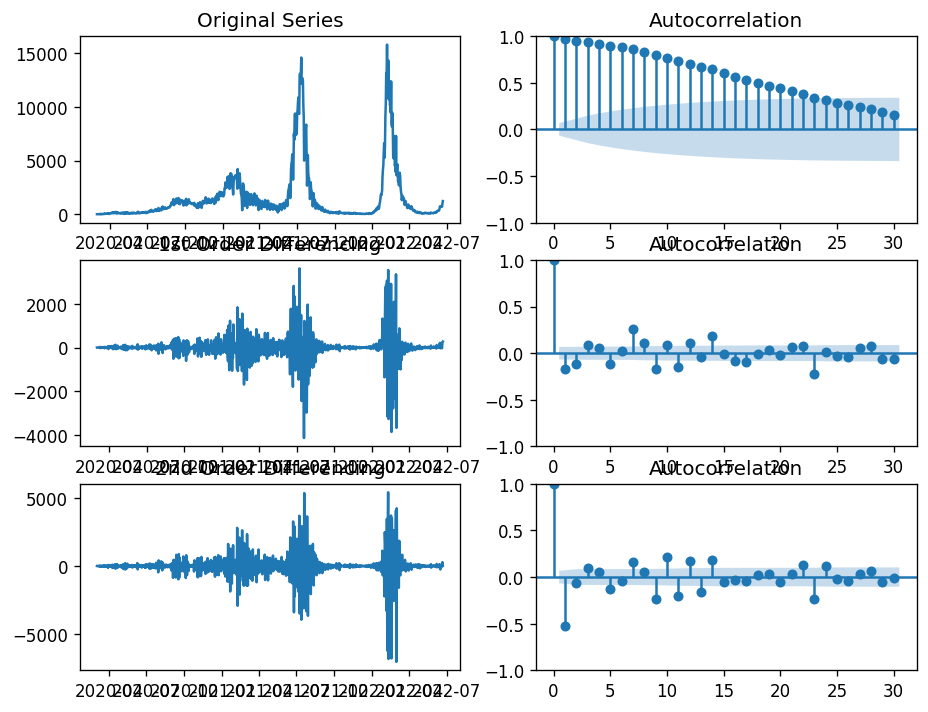

ADF Statistic 1st d order: -6.336015
p-value 1st d order: 0.000000


In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams.update({'figure.figsize': (9, 7), 'figure.dpi': 120})


# Original Series
fig, axes = plt.subplots(3, 2)
axes[0, 0].plot(positif_harian)
axes[0, 0].set_title('Original Series')
plot_acf(positif_harian, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(positif_harian.diff())
axes[1, 0].set_title('1st Order Differencing')
plot_acf(positif_harian.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(positif_harian.diff().diff())
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(positif_harian.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

result = adfuller(positif_harian.diff().dropna())
print('ADF Statistic 1st d order: %f' % result[0])
print('p-value 1st d order: %f' % result[1])


Kalo mau dikasi differencing 1st order juga gaapa, lebih bagus keknya

### Cari AR term (p order)

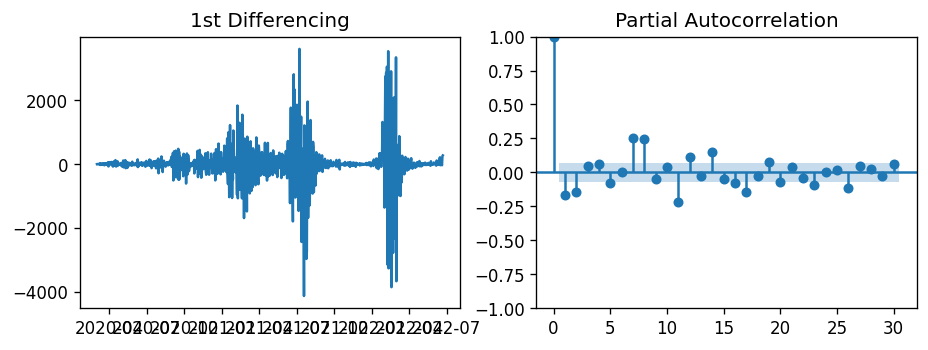

In [31]:
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(positif_harian.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 5))
plot_pacf(positif_harian.diff().dropna(), ax=axes[1])

plt.show()

lag 1 signifikan ya ges, jadi kayanya p nya 1. Nanti coba coba aja wkwkkw

### Cari MA term (q order)

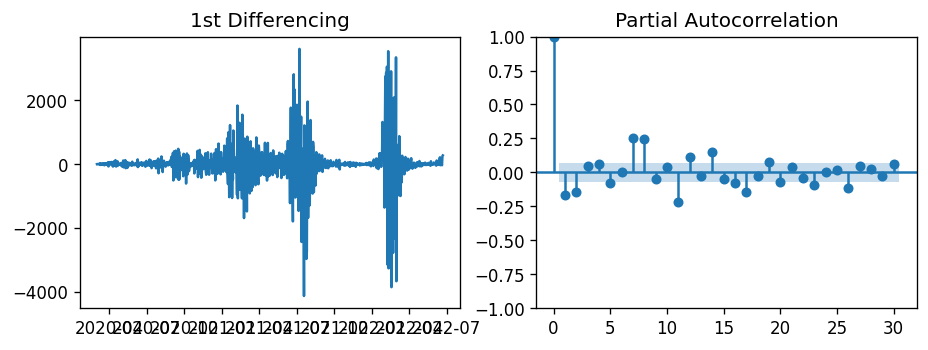

In [32]:
plt.rcParams.update({'figure.figsize': (9, 3), 'figure.dpi': 120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(positif_harian.diff())
axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0, 5))
plot_pacf(positif_harian.diff().dropna(), ax=axes[1])

plt.show()

Karena yang lagnya keluar biru bitu ada 4, kita coba q nya 4. Kalo ternyata over differenced, mending di tambah lagi MA term nya

## Modeling

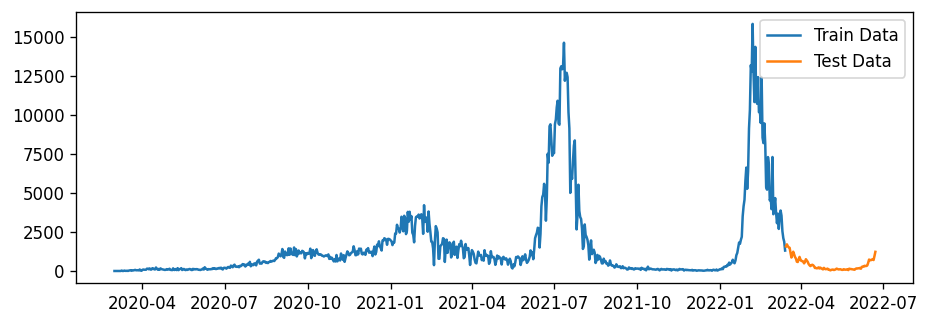

In [128]:
import statsmodels.api as sm

START_INDEX = 0 # index dari obs pertama
PENGURANG = 100 # pengurangan data buat tes

train = positif_harian.iloc[START_INDEX:len(positif_harian) - PENGURANG]
test = positif_harian.iloc[len(positif_harian) - PENGURANG:]

plt.plot(train.index, train["Positif Harian"], label="Train Data")
plt.plot(test.index, test["Positif Harian"], label="Test Data")
plt.legend()
plt.show()

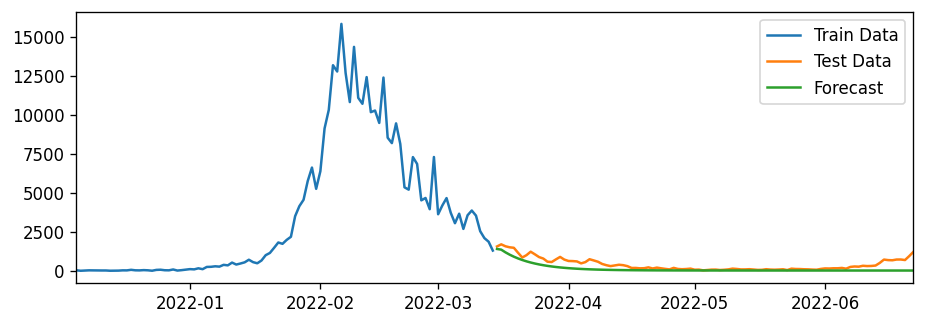

In [130]:
model_2 = sm.tsa.arima.ARIMA(train, order=(1, 2, 4))
history  = model_2.fit()

fc = history.forecast(steps=len(test))

# plot the forecast
plt.plot(train.index, train["Positif Harian"], label="Train Data")
plt.plot(test.index, test["Positif Harian"], label="Test Data")
plt.plot(fc, label="Forecast")
plt.xlim(train.index[-100], test.index[-1])
plt.legend()

In [141]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))             
    mae = np.mean(np.abs(forecast - actual))     
    rmse = np.mean((forecast - actual)**2)**.5  
                    
    return({'mape': mape,  'mae': mae,
           'rmse': rmse,})


forecast_accuracy(fc.values, test.values)

{'mape': 1.1569018664171395,
 'mae': 393.1422237919875,
 'rmse': 560.5305704427291}